In [5]:
Mjj_selection = 700.

vae_loss = 'mae'

SM_eff = 1e-2

def computeDiscriminatingVar(x):
    out = x[:,-2]/x[:,1]+x[:,-1]/x[:,6]
    out *= 1e5
    return out

# def computeDiscriminatingVar(x):
#     out = x[:,-2]+x[:,-1]
#     return out*1e4

# Imports

In [6]:
from __future__ import print_function

import numpy as np
import h5py, os, sys, glob
sys.path.append('../lib')
from glob import glob

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from prettytable import PrettyTable

import ROOT as rt

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

# Get the discrimination on the side-band

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1Loss', 'j2Loss']
(209109, 13)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


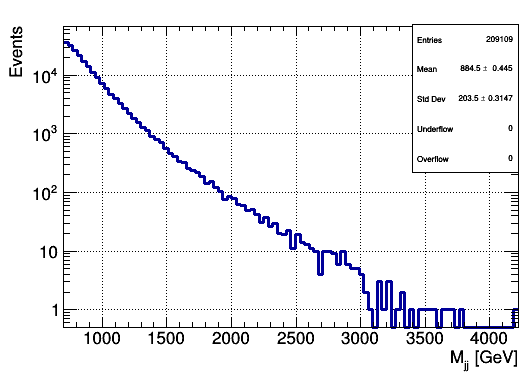

In [7]:
f = h5py.File('../data/vae_'+vae_loss+'/qcd_dEta_sideband_results.h5', 'r')
print(list(f.get("labels")))

data_side = np.array(f.get("results"))

# apply the dijet mass cut
data_side = data_side[data_side[:,0] > Mjj_selection]
print(data_side.shape)

c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_side[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                opt='overflow', 
                binning=[100, Mjj_selection, np.max(data_side[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [8]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=5,
                                min_samples_split=5,
                                validation_fraction=0.5,
                                n_iter_no_change=10,
                                tol=1e-5,
                                verbose=1)

x = np.reshape(data_side[:,0], (-1,1))
y = computeDiscriminatingVar(data_side)
gbr_cut.fit(x, y);

      Iter       Train Loss   Remaining Time 
         1           0.3828           15.61s
         2           0.3822           11.96s
         3           0.3817           10.49s
         4           0.3813            9.79s
         5           0.3810            9.29s
         6           0.3807            9.16s
         7           0.3805            9.40s
         8           0.3803            9.14s
         9           0.3800            8.90s
        10           0.3798            8.68s
        20           0.3786            7.60s
        30           0.3781            7.09s


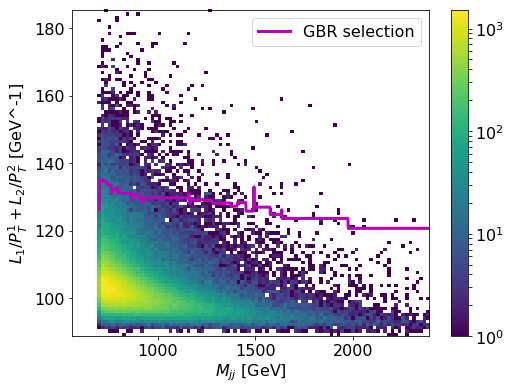

In [9]:
plt.figure(figsize=(8, 6))
x_min = Mjj_selection*0.8
x_max = np.quantile(x, 0.999)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.quantile(y, 1-1e-4))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [10]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

In [13]:
def plotMassSpectrum(mJJ_pass, mJJ_rej, title=''):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c

<ROOT.TCanvas object ("c_out_ratio") at 0x7f9054df3a20>

Warning in <TROOT::Append>: Replacing existing TH1: h_acc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_rej (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


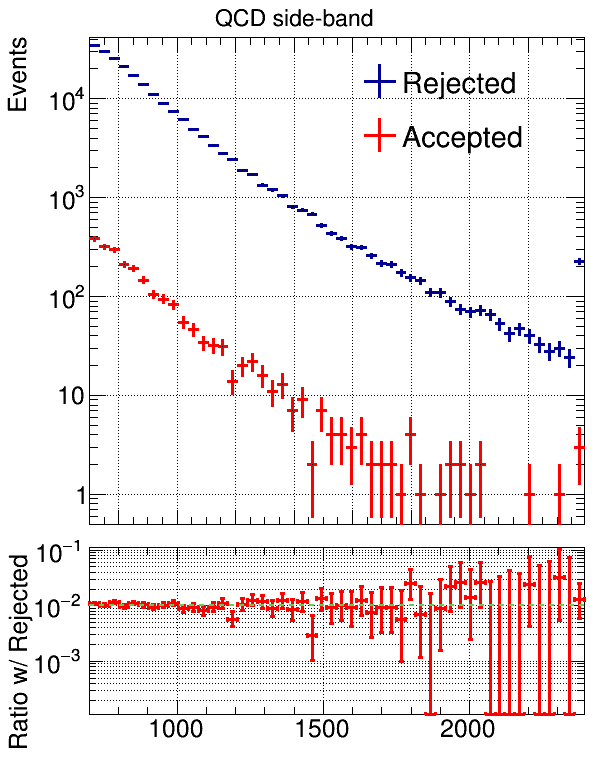

In [14]:
x = x.flatten()
binning=[50, Mjj_selection, np.quantile(x, 0.999)]

sel = getSelection(x, y)

plotMassSpectrum(x[sel], x[np.logical_not(sel)], 'QCD side-band')

# Define and test Hypotesis test

In [15]:
import scipy as sp
def HypotesisTets(h_a, h_r, eff, N_asymov = 100000, show_hist = False):
    aux, _ = rootTH1_to_np(h_r)
    nu = eff*aux/(1-eff)
    
    o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
    
    probs = sp.stats.poisson.pmf(o_asymov, nu)
    nll = -np.log(probs)
    s_asymov = np.sum(nll, axis=-1)
    
    aux, _ = rootTH1_to_np(h_a)
    probs_obs = sp.stats.poisson.pmf(aux.astype(np.int), nu)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    
    p_val = np.sum(s_asymov > s_obs)/float(N_asymov)
    
    
    if show_hist:
        plt.hist(s_asymov)

    return p_val

In [16]:
HypotesisTets(h_a, h_r, SM_eff)

0.44181

# Analyze signal region

In [32]:
sample_loc = {'qcd':'qcd_dEta_signalregion_results.h5',
              'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_results.h5',
              'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
              'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':'QCD',
                'AtoZZZ':'$A\toZZZ$',
                'GtoWW':'$G\toWW$',
                'GtoBtt':'$G_{B}\tot\bar{t}$',
                'GtoNtt':'$G_{N}\tot\bar{t}$'
               }

BSM_samples = ['AtoZZZ', 'GtoWW', 'GtoBtt', 'GtoNtt']

sample_eff = {'qcd': 0.11278,
                   'AtoZZZ': 0.65148,
                   'GtoWW': 0.5363,
                   'GtoBtt': 0.668531,
                   'GtoNtt': 0.67006
                  }

sample_xsec = {'qcd': 8734.0 #pb
              }

### Get the data

In [30]:
data = {}
table = PrettyTable()
table.field_names = ['Sample', 'Tot. evts', 'Sel. evts', 'Eff VAE[%]']

for n, fname in sample_loc.iteritems():
    f = h5py.File('../data/vae_'+vae_loss+'/'+fname, 'r')
    x = np.array(f.get("results"))

    # apply the dijet mass cut
    sel_Mjj = x[:,0] > Mjj_selection
    x = x[sel_Mjj]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(x[:,0], dVar)
    x = np.column_stack((x, dVar, sel))
    
    dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.3f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], np.sum(data[n]['sel']), eff])
    
print(table)

+--------+-----------+-----------+------------+
| Sample | Tot. evts | Sel. evts | Eff VAE[%] |
+--------+-----------+-----------+------------+
| GtoBtt |   65666   |   12521   |   19.068   |
| GtoWW  |   53630   |   12641   |   23.571   |
| GtoNtt |   64179   |   12305   |   19.173   |
| AtoZZZ |   65148   |   13403   |   20.573   |
|  qcd   |   471448  |    4898   |   1.039    |
+--------+-----------+-----------+------------+


## Find the p-value as a function of xsec

In [31]:
xsec_BSM = 100 #pb
name_BSM = 'GtoWW'

In [ ]:
d_SM = data['qcd']['mJJ']

lumi = d_SM.shape[0]/(sample_xsec['qcd'] * sample_eff['qcd']) #pb^{-1}

h_a_SM = create_TH1D(d_SM[data['qcd']['sel']], 
                     name='h_acc', title='Accepted',
                     binning=binning,
                     opt='overflow'
                    )

h_r_SM = create_TH1D(d_SM[np.logical_not(data['qcd']['sel'])], 
                     name='h_rej', title='Rejected',
                     axis_title=['M_{jj} [GeV]', 'Events'],
                     binning=binning,
                     opt='overflow'
                    )

h_a_BSM = create_TH1D(data[name_BSM]['mJJ'][data[name_BSM]['sel']], 
              name='h_a'+name_BSM,
              binning=h_a.binning,
              opt='overflow'
             )

h_r_BSM = create_TH1D(data[name_BSM]['mJJ'][np.logical_not(data[name_BSM]['sel'])], 
              name='h_r'+name_BSM,
              binning=h_r.binning,
              opt='overflow'
             )

In [ ]:
N_BSM

aux_h_a = h_a.Clone('aux_h_a'+name_BSM)
aux_h_a.Add(h_a, h_a_BSM, 1, scale_f)

aux_h_r = h_r.Clone('aux_h_r'+name_BSM)
aux_h_r.Add(h_r, h_r_BSM, 1, scale_f)
aux_h_r.GetYaxis().SetRangeUser(0.5, 1.2*aux_h_r.GetMaximum())

c_an = make_effiency_plot([aux_h_r, aux_h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E')
c_an.pad1.SetLogy()
c_an.pad2.SetLogy()

c_an.pad2.cd()
ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
ln.SetLineWidth(2)
ln.SetLineStyle(7)
ln.SetLineColor(8)
ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

c_an.Draw()

p_val = HypotesisTets(aux_h_a, aux_h_r, SM_eff)
print('p-val:', p_val)